In [68]:
%pip install torch --upgrade
%pip install git+https://github.com/amazon-science/chronos-forecasting.git

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/amazon-science/chronos-forecasting.git to /private/var/folders/d8/xf5yjrpn5zvd1j56c42jys2w0000gn/T/pip-req-build-d2t610eh
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/d8/xf5yjrpn5zvd1j56c42jys2w0000gn/T/pip-req-build-d2t610eh
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 9d59057b72a1ddd52e163c536d0f99631eea4857
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import pandas as pd 
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
path = "/Users/amrtamer/Documents/Internship"

In [3]:
data = pd.read_pickle(path + r'/data/Volve/Volve_cleaned_prepared.pkl')
data.head()

,well_name,WELL_BORE_CODE,date,prod_hrs,bhp,bht,dp_tubing,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,whp,...,linear_regressor,EMA_short,EMA_medium,EMA_long,Rolling_short,Rolling_medium,Rolling_long,Lag_short,Lag_medium,Lag_long
0,7405,NO 15/9-F-1 C,2014-04-22,0.268405,1.029311,0.605973,0.396167,-2.016027,-0.533280,3.281836,...,-0.101892,-0.103579,-0.104768,-0.106929,-0.001355,-0.002618,-0.00519,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,7405,NO 15/9-F-1 C,2014-04-23,0.268405,0.845795,0.634777,0.239818,0.088113,-0.419656,2.849981,...,-0.101892,-0.103579,-0.104768,-0.106929,-0.001355,-0.002618,-0.00519,"[0.0, 0.0, -0.10230979661544379]","[0.0, 0.0, 0.0, 0.0, -0.10230979661544379]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,7405,NO 15/9-F-1 C,2014-04-24,0.268405,0.775025,0.639809,0.199890,-0.688434,-0.402874,2.607708,...,-0.101892,-0.009618,-0.053295,-0.079801,-0.001355,-0.002618,-0.00519,"[0.0, -0.10230979661544379, -0.10230979661544379]","[0.0, 0.0, 0.0, -0.10230979661544379, -0.10230...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.10..."
3,7405,NO 15/9-F-1 C,2014-04-25,0.268405,0.705033,0.642084,0.161493,1.145283,-0.379061,2.364038,...,-0.114759,-0.020781,-0.051611,-0.076565,-0.001355,-0.002618,-0.00519,"[-0.10230979661544379, -0.10230979661544379, 0...","[0.0, 0.0, -0.10230979661544379, -0.1023097966...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1023097..."
4,7405,NO 15/9-F-1 C,2014-04-26,0.268405,0.625357,0.643889,0.117221,1.145283,-0.340115,2.088747,...,0.082297,-0.004428,-0.037199,-0.066767,-0.009496,-0.002618,-0.00519,"[-0.10230979661544379, 0.1777063666263608, -0....","[0.0, -0.10230979661544379, -0.102309796615443...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.102309796615..."


In [4]:
univariate_feature = "oil_rate"
days_window = 5
predictions_days = 14
training_gap = days_window + predictions_days

In [30]:
# sequences = []
# for well_name in data['well_name'].unique():
#     well_data = data[data['well_name'] == well_name].sort_values(by='date').reset_index()
#     for i in range(len(well_data) - training_gap + 1):
#         inputs = well_data.iloc[i:i + days_window][univariate_feature].values
#         targets = well_data.iloc[i + days_window:i + days_window + predictions_days][univariate_feature].values
#         inputs_dates = list(well_data.iloc[i:i + days_window]['date'])
#         targets_dates = list(well_data.iloc[i + days_window:i + days_window + predictions_days]['date'])
#         inputs_index = list(well_data.iloc[i:i + days_window]['index'])
#         targets_index = list(well_data.iloc[i + days_window:i + days_window + predictions_days]['index'])
#         sequences.append((well_name, inputs_dates, targets_dates, inputs_index, targets_index, inputs, targets))
#         if len(well_data.iloc[i:i + days_window + predictions_days]['well_name'].unique()) > 1:
#           print('violation')

# dataset = pd.DataFrame(sequences, columns=['well_name', 'inputs_dates', 'targets_dates', 'inputs_index', 'targets_index', 'inputs', 'targets', ])
# dataset

,well_name,inputs_dates,targets_dates,inputs_index,targets_index,inputs,targets
0,7405,"[2014-04-22, 2014-04-23, 2014-04-24, 2014-04-2...","[2014-04-27, 2014-04-28, 2014-04-29, 2014-04-3...","[0, 1, 2, 3, 4]","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[-0.10230979661544379, -0.10230979661544379, 0...","[0.03143471750891875, 0.02854945901197042, -0...."
1,7405,"[2014-04-23, 2014-04-24, 2014-04-25, 2014-04-2...","[2014-04-28, 2014-04-29, 2014-04-30, 2014-05-0...","[1, 2, 3, 4, 5]","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[-0.10230979661544379, 0.1777063666263608, -0....","[0.02854945901197042, -0.019769490247049614, -..."
2,7405,"[2014-04-24, 2014-04-25, 2014-04-26, 2014-04-2...","[2014-04-29, 2014-04-30, 2014-05-01, 2014-05-0...","[2, 3, 4, 5, 6]","[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...","[0.1777063666263608, -0.042237984263791245, 0....","[-0.019769490247049614, -0.05909665922823859, ..."
3,7405,"[2014-04-25, 2014-04-26, 2014-04-27, 2014-04-2...","[2014-04-30, 2014-05-01, 2014-05-02, 2014-05-0...","[3, 4, 5, 6, 7]","[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...","[-0.042237984263791245, 0.028673634694117614, ...","[-0.05909665922823859, -0.06838792203360104, -..."
4,7405,"[2014-04-26, 2014-04-27, 2014-04-28, 2014-04-2...","[2014-05-01, 2014-05-02, 2014-05-03, 2014-05-0...","[4, 5, 6, 7, 8]","[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...","[0.028673634694117614, 0.03143471750891875, 0....","[-0.06838792203360104, -0.16981754099214288, -..."
...,...,...,...,...,...,...,...
7874,5769,"[2016-08-04, 2016-08-05, 2016-08-06, 2016-08-0...","[2016-08-09, 2016-08-10, 2016-08-11, 2016-08-1...","[7964, 7965, 7966, 7967, 7968]","[7969, 7970, 7971, 7972, 7973, 7974, 7975, 797...","[-0.7225746333923075, -0.7166507229086997, -0....","[-0.7318767962210462, -0.7237141278873048, -0...."
7875,5769,"[2016-08-05, 2016-08-06, 2016-08-07, 2016-08-0...","[2016-08-10, 2016-08-11, 2016-08-12, 2016-08-1...","[7965, 7966, 7967, 7968, 7969]","[7970, 7971, 7972, 7973, 7974, 7975, 7976, 797...","[-0.7166507229086997, -0.7226768957187816, -0....","[-0.7237141278873048, -0.7192072810705527, -0...."
7876,5769,"[2016-08-06, 2016-08-07, 2016-08-08, 2016-08-0...","[2016-08-11, 2016-08-12, 2016-08-13, 2016-08-1...","[7966, 7967, 7968, 7969, 7970]","[7971, 7972, 7973, 7974, 7975, 7976, 7977, 797...","[-0.7226768957187816, -0.7202079909796208, -0....","[-0.7192072810705527, -0.7133929373653101, -0...."
7877,5769,"[2016-08-07, 2016-08-08, 2016-08-09, 2016-08-1...","[2016-08-12, 2016-08-13, 2016-08-14, 2016-08-1...","[7967, 7968, 7969, 7970, 7971]","[7972, 7973, 7974, 7975, 7976, 7977, 7978, 797...","[-0.7202079909796208, -0.7207996515827926, -0....","[-0.7133929373653101, -0.7128670168291575, -0...."


In [5]:
train_size = 0.6
val_size = 0.2
test_size = 0.2

In [6]:
test_size_param1 = test_size
test_size_param2 = val_size / (1 - test_size_param1)

In [33]:

# train_wells = []
# test_wells = []
# for i in dataset['well_name'].unique():
#     well = dataset[dataset['well_name'] == i]
#     train_set_length = int((train_size + val_size) * len(well))
#     train_wells.append(well[:train_set_length + 1])
#     test_set_length = int(test_size * len(well))
#     test_wells.append(well[-test_set_length:])

# # Flatten the lists of DataFrames
# temp_data = pd.concat(train_wells).reset_index(drop=True)
# data_test = pd.concat(test_wells).reset_index(drop=True)

# data_train, data_val = train_test_split(temp_data, test_size=test_size_param2, stratify=temp_data['well_name'], shuffle=True)

# data_train.reset_index(drop=True, inplace=True)
# data_val.reset_index(drop=True, inplace=True)
# data_test.reset_index(drop=True, inplace=True)

# data_train.to_pickle(path + "/data/Volve/data_univariate_train.pkl")
# data_val.to_pickle(path + "/data/Volve/data_univariate_val.pkl")
# data_test.to_pickle(path + "/data/Volve/data_univariate_test.pkl")

In [7]:
data_train = pd.read_pickle(path + "/data/Volve/data_univariate_train.pkl")
data_val = pd.read_pickle(path + "/data/Volve/data_univariate_val.pkl")
data_test = pd.read_pickle(path + "/data/Volve/data_univariate_test.pkl")
data_val.shape, data_test.shape

((1577, 7), (1573, 7))

In [8]:
batch_size = 50

In [9]:
class UivariateTimeSeriesDataset(Dataset):
    def __init__(self, sequences_df):
        self.sequences_df = sequences_df

    def __len__(self):
        return len(self.sequences_df)

    def __getitem__(self, idx):
        inputs = self.sequences_df.iloc[idx]['inputs']
        targets = self.sequences_df.iloc[idx]['targets']
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).squeeze()

train_dataset = UivariateTimeSeriesDataset(data_train)
val_dataset = UivariateTimeSeriesDataset(data_val)
test_dataset = UivariateTimeSeriesDataset(data_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def calculate_metrics(y_true, y_pred):
    # Calculate metrics for the predictions
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred, multioutput='uniform_average')
    loss = mean_squared_error(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Loss': loss}

@torch.no_grad()
def evaluate(mode, model):
    loader_dict = {'train': train_loader, 'val': val_loader, 'test': test_loader}
    loader = loader_dict[mode]
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_targets = []
    test_losses = []
    for X_batch, Y_batch in loader:
        forecast = model.predict(context=X_batch, prediction_length=predictions_days, num_samples=num_samples)
        prediction = forecast.mean(axis=1)
        loss = F.mse_loss(prediction, Y_batch)
        test_losses.append(loss.item())  # Collect test loss
        B, T = Y_batch.shape
        prediction = prediction.view(B*T)
        Y_batch = Y_batch.view(B*T)
        # Convert predictions and targets to NumPy arrays
        all_preds.append(prediction.cpu().numpy())  # .cpu() moves tensor to CPU, .numpy() converts to NumPy array
        all_targets.append(Y_batch.cpu().numpy())
    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    # Calculate metrics
    metrics = calculate_metrics(all_targets, all_preds)
    metrics['Loss'] = np.mean(test_losses)
    print(f"Metrics on {mode} set:\n")
    print(f"Loss is {metrics['Loss']:.4f}")
    print(f"MAE is {metrics['MAE']:.4f}")
    print(f"RMSE is {metrics['RMSE']:.4f}")
    print(f"R² is {metrics['R2']:.4f}")
    print("\n")
    return metrics

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    num_samples = trial.suggest_int("num_samples", 10, 50, step=10)
    size = trial.suggest_categorical("size", ["tiny", "mini", "small", "base", "large"])
    # Load the model
    pipeline = ChronosPipeline.from_pretrained(
        f"amazon/chronos-t5-{size}",
        device_map="mps",  # use "cpu" for CPU inference and "mps" for Apple Silicon
        torch_dtype=torch.bfloat16,  # torch.bfloat16,
    )
    
    avg_loss = 0
    device = "cpu"
    
    for X_batch, Y_batch in val_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        
        forecast = pipeline.predict(
            context=X_batch,
            prediction_length=predictions_days,
            num_samples=num_samples,
        )
        
        prediction = forecast.mean(axis=1)
        prediction = prediction.view(prediction.shape[0] * prediction.shape[1])
        Y_batch = Y_batch.view(Y_batch.shape[0] * Y_batch.shape[1])
        
        loss = F.mse_loss(prediction, Y_batch)
        avg_loss += loss.item()
    
    val_loss = avg_loss / len(val_loader)
    return val_loss

In [14]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2024-07-08 14:02:15,492] A new study created in memory with name: no-name-561035a0-8901-401f-926f-1e5fa9fdb5e0
/Users/amrtamer/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
[I 2024-07-08 14:03:14,934] Trial 0 finished with value: 0.07399260968668386 and parameters: {'num_samples': 50, 'size': 'small'}. Best is trial 0 with value: 0.07399260968668386.
[I 2024-07-08 14:03:50,849] Trial 1 finished with value: 0.08172283679596148 and parameters: {'num_samples': 20, 'size': 'small'}. Best is trial 0 with value: 0.07399260968668386.
[I 2024-07-08 14:04:20,112] Trial 2 finished with value: 0.06905774885672145 and parameters: {'num_samples': 30, 'size': 'mini'}. Best is trial 2 with value: 0.06905774885672145.
[I 2024-07-08 14:09:04,553] Trial 3 finishe

Best parameters: {'num_samples': 50, 'size': 'tiny'}


In [16]:
size = "small"
num_samples = 50

In [17]:
pipeline = ChronosPipeline.from_pretrained(
    f"amazon/chronos-t5-{size}",
    device_map="mps",
    torch_dtype=torch.float32, # you can use torch.bfloat16 for faster inference
)

/Users/amrtamer/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(len(input_values)), input_values, marker='o', label='Input Values')
plt.plot(range(len(input_values), len(input_values) + predictions_days), prediction, marker='o', label='Forecasted Values')
plt.axvline(x=len(input_values)-1, color='r', linestyle='--', label='Forecast Start')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('14-Day Forecast')
plt.legend()
plt.grid(True)
plt.show()


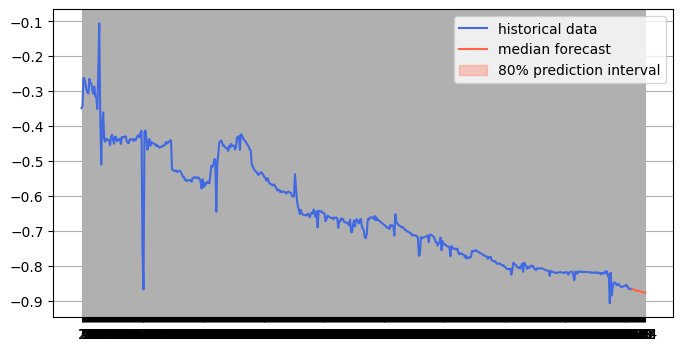

In [16]:
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df['oil_rate'], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.xticks(ticks=np.arange(1, len(df) + prediction_length), labels=np.arange(1, len(df) + prediction_length))
plt.legend()
plt.grid()
plt.show()